In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import csv

In [2]:
def plot_series(x, y, format="-", start=0, end=None, 
                title=None, xlabel=None, ylabel=None, legend=None ):
    """
    Visualizes time series data

    Args:
      x (array of int) - contains values for the x-axis
      y (array of int or tuple of arrays) - contains the values for the y-axis
      format (string) - line style when plotting the graph
      start (int) - first time step to plot
      end (int) - last time step to plot
      title (string) - title of the plot
      xlabel (string) - label for the x-axis
      ylabel (string) - label for the y-axis
      legend (list of strings) - legend for the plot
    """

    # Setup dimensions of the graph figure
    plt.figure(figsize=(10, 6))
    
    # Check if there are more than two series to plot
    if type(y) is tuple:

      # Loop over the y elements
      for y_curr in y:

        # Plot the x and current y values
        plt.plot(x[start:end], y_curr[start:end], format)

    else:
      # Plot the x and y values
      plt.plot(x[start:end], y[start:end], format)

    # Label the x-axis
    plt.xlabel(xlabel)

    # Label the y-axis
    plt.ylabel(ylabel)

    # Set the legend
    if legend:
      plt.legend(legend)

    # Set the title
    plt.title(title)

    # Overlay a grid on the graph
    plt.grid(True)

    # Draw the graph on screen
    plt.show()

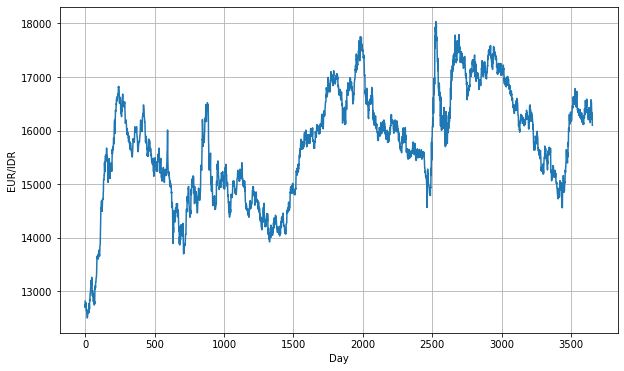

In [3]:
# Initialize lists
time_step = []
sunspots = []

# Open CSV file
with open('./currency_data_10_years.csv') as csvfile:
  
    # Initialize reader
    reader = csv.reader(csvfile, delimiter=',')

    # Skip the first line
    next(reader)

    # Append row and sunspot number to lists
    for i,row in enumerate(reader):
        time_step.append(int(i))
        sunspots.append(float(row[1]))

# Convert lists to numpy arrays
time = np.array(time_step)
series = np.array(sunspots)

# Preview the data
plot_series(time, series, xlabel='Day', ylabel='EUR/IDR')

In [4]:
# Define the split time
split_time = 3200

# Get the train set 
time_train = time[:split_time]
x_train = series[:split_time]

# Get the validation set
time_valid = time[split_time:]
x_valid = series[split_time:]

In [5]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    """Generates dataset windows

    Args:
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the feature
      batch_size (int) - the batch size
      shuffle_buffer(int) - buffer size to use for the shuffle method

    Returns:
      dataset (TF Dataset) - TF Dataset containing time windows
    """
  
    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)
    
    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    
    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))

    # Create tuples with features and labels 
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))

    # Shuffle the windows
    dataset = dataset.shuffle(shuffle_buffer)
    
    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)
    
    return dataset

In [6]:
# Parameters
window_size = 30
batch_size = 32
shuffle_buffer_size = 1000

# Generate the dataset windows
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

In [7]:
# Build the model
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(30, input_shape=[window_size], activation="relu"), 
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(1)
])

# Print the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 30)                930       
                                                                 
 dense_1 (Dense)             (None, 10)                310       
                                                                 
 dense_2 (Dense)             (None, 1)                 11        
                                                                 
Total params: 1,251
Trainable params: 1,251
Non-trainable params: 0
_________________________________________________________________


In [8]:
# Get initial weights
init_weights = model.get_weights()

# Reset states generated by Keras
tf.keras.backend.clear_session()

# Reset the weights
model.set_weights(init_weights)

In [9]:
# Set the learning rate scheduler
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))

# Initialize the optimizer
optimizer = tf.keras.optimizers.SGD(momentum=0.9)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer)

# Train the model
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
100/100 [==============================] - 2s 14ms/step - loss: 4374.3013 - lr: 1.0000e-08
Epoch 2/100
100/100 [==============================] - 0s 3ms/step - loss: 189.6640 - lr: 1.1220e-08
Epoch 3/100
100/100 [==============================] - 0s 3ms/step - loss: 191.7533 - lr: 1.2589e-08
Epoch 4/100
100/100 [==============================] - 0s 3ms/step - loss: 187.6837 - lr: 1.4125e-08
Epoch 5/100
100/100 [==============================] - 0s 3ms/step - loss: 180.9664 - lr: 1.5849e-08
Epoch 6/100
100/100 [==============================] - 0s 3ms/step - loss: 179.8949 - lr: 1.7783e-08
Epoch 7/100
100/100 [==============================] - 0s 3ms/step - loss: 184.9127 - lr: 1.9953e-08
Epoch 8/100
100/100 [==============================] - 0s 3ms/step - loss: 179.2737 - lr: 2.2387e-08
Epoch 9/100
100/100 [==============================] - 0s 3ms/step - loss: 176.7237 - lr: 2.5119e-08
Epoch 10/100
100/100 [==============================] - 0s 3ms/step - loss: 179.0292 - lr

(1e-08, 1.5e-08, 0.0, 20000.0)

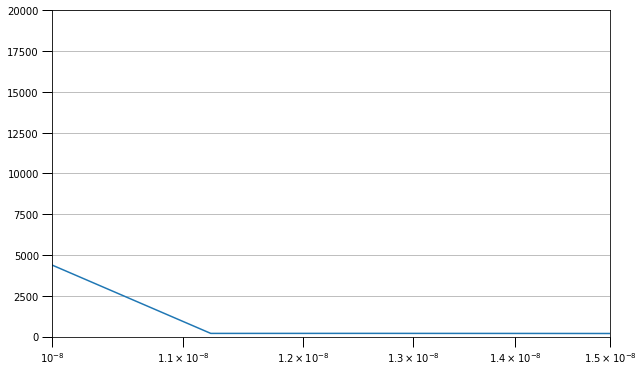

In [10]:
# Define the learning rate array
lrs = 1e-8 * (10 ** (np.arange(100) / 20))

# Set the figure size
plt.figure(figsize=(10, 6))

# Set the grid
plt.grid(True)

# Plot the loss in log scale
plt.semilogx(lrs, history.history["loss"])

# Increase the tickmarks size
plt.tick_params('both', length=10, width=1, which='both')

# Set the plot boundaries
plt.axis([1e-8, 1.5e-8, 0, 20000])

In [11]:
# Reset states generated by Keras
tf.keras.backend.clear_session()

# Reset the weights
model.set_weights(init_weights)

In [12]:
# Set the learning rate
learning_rate = 1e-8

# Set the optimizer 
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

In [13]:
# Train the model
history = model.fit(train_set,epochs=100)

Epoch 1/100
100/100 [==============================] - 1s 3ms/step - loss: 4380.9414 - mae: 4381.4414
Epoch 2/100
100/100 [==============================] - 0s 3ms/step - loss: 192.1189 - mae: 192.6186
Epoch 3/100
100/100 [==============================] - 0s 3ms/step - loss: 189.0312 - mae: 189.5308
Epoch 4/100
100/100 [==============================] - 0s 3ms/step - loss: 188.8808 - mae: 189.3802
Epoch 5/100
100/100 [==============================] - 0s 3ms/step - loss: 187.1078 - mae: 187.6071
Epoch 6/100
100/100 [==============================] - 0s 3ms/step - loss: 178.9893 - mae: 179.4886
Epoch 7/100
100/100 [==============================] - 0s 3ms/step - loss: 178.0728 - mae: 178.5717
Epoch 8/100
100/100 [==============================] - 0s 3ms/step - loss: 180.1528 - mae: 180.6521
Epoch 9/100
100/100 [==============================] - 0s 3ms/step - loss: 179.6494 - mae: 180.1490
Epoch 10/100
100/100 [==============================] - 0s 3ms/step - loss: 179.1181 - mae: 179.61

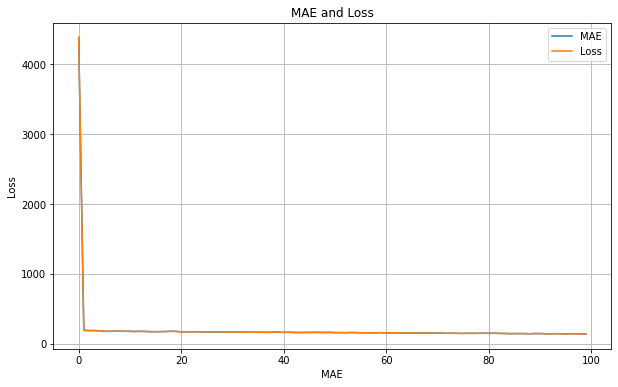

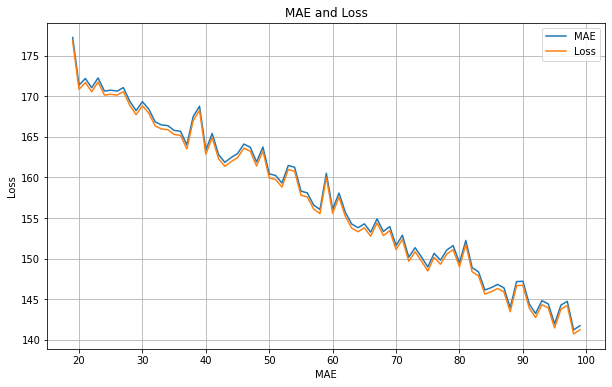

In [14]:
# Get mae and loss from history log
mae=history.history['mae']
loss=history.history['loss']

# Get number of epochs
epochs=range(len(loss)) 

# Plot mae and loss
plot_series(
    x=epochs, 
    y=(mae, loss), 
    title='MAE and Loss', 
    xlabel='MAE',
    ylabel='Loss',
    legend=['MAE', 'Loss']
    )

# Only plot the last 80% of the epochs
zoom_split = int(epochs[-1] * 0.2)
epochs_zoom = epochs[zoom_split:]
mae_zoom = mae[zoom_split:]
loss_zoom = loss[zoom_split:]

# Plot zoomed mae and loss
plot_series(
    x=epochs_zoom, 
    y=(mae_zoom, loss_zoom), 
    title='MAE and Loss', 
    xlabel='MAE',
    ylabel='Loss',
    legend=['MAE', 'Loss']
    )

In [15]:
def model_forecast(model, series, window_size, batch_size):
    """Uses an input model to generate predictions on data windows

    Args:
      model (TF Keras Model) - model that accepts data windows
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the window
      batch_size (int) - the batch size

    Returns:
      forecast (numpy array) - array containing predictions
    """

    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size, shift=1, drop_remainder=True)

    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda w: w.batch(window_size))
    
    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)
    
    # Get predictions on the entire dataset
    forecast = model.predict(dataset)
    
    return forecast

15/15 [==============================] - 0s 5ms/step


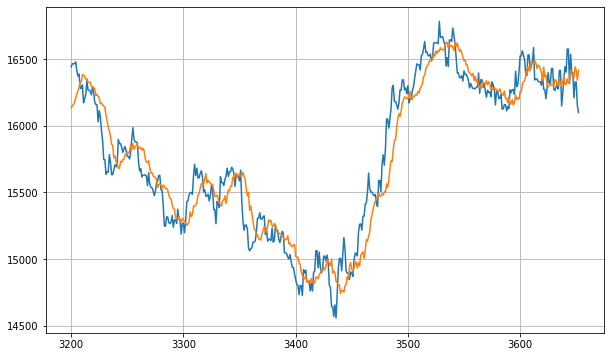

In [16]:
# Reduce the original series
forecast_series = series[split_time-window_size:-1]

# Use helper function to generate predictions
forecast = model_forecast(model, forecast_series, window_size, batch_size)

# Drop single dimensional axis
results = forecast.squeeze()

# Plot the results
plot_series(time_valid, (x_valid, results))

114/114 [==============================] - 0s 4ms/step


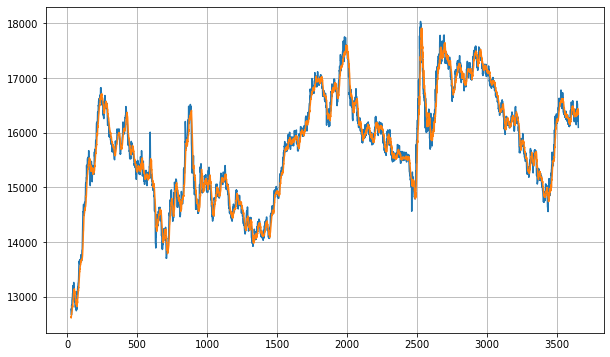

In [17]:
# Reduce the original series
forecast_series2 = series

# Use helper function to generate predictions
forecast2 = model_forecast(model, forecast_series2, window_size, batch_size)

# Drop single dimensional axis
results2 = forecast2.squeeze()
valid_y_series = series[window_size-1:]
valid_y_time = time[window_size-1:]

# Plot the results
plot_series(valid_y_time, (valid_y_series, results2))

In [18]:
# Compute the MAE valid
print(tf.keras.metrics.mean_absolute_error(x_valid, results).numpy())

128.54982


In [19]:
print(f'2 last Actual Price = {x_valid[-2:]}, Predicted Price = {results[-2:]}')

2 last Actual Price = [16152.48258  16098.499876], Predicted Price = [16341.074 16415.73 ]


In [20]:
# import os
# path = "./saved_model"

# def get_model_dir():
#     """Returns the path where to save the current model.
#     The path is as follows: './saved_models/{incremental_integer}
#     Note: all sub-directories inside 'saved_models' must have an incremental integer as name

#     Returns:
#     - Path to save a new model (str) 
#     """
#     # create 'saved_models' directory if it does not exist
#     if not os.path.exists(path):
#         os.makedirs(path)

#     # check for model directories inside 'saved_models'
#     model_dirs = [int(i) for i in os.listdir(path)]

#     # if there is no prior model, current model has version 1
#     # otherwise, current model version is highest available version incremented by 1 
#     current_model = "1" if len(model_dirs)==0 else str(max(model_dirs)+1)

#     return path + "/" + current_model + "/"

In [21]:
# # !mkdir -p saved_model
# path = get_model_dir()
# model.save(path)

In [22]:
into_future = 100

# 1. Create function to make preds
def make_future_forecast(values, model, into_future, window_size=window_size) -> list:
    """
    Make future forecasts into_future steps after value ends.

    Returns future forecasts as a list of floats.
    """
    # 2. Create an empty list for future forecasts/prepare data to forecast on
    future_forecast = []
    last_window = values[-window_size:]

    # 3. Make INTO_FUTURE number of predictions, altering the data which gets predicted on each
    for _ in range(into_future):
        # Predict on the last window then append it again, again, again (our model will eventually start to make forecasts on its own forecasts)
        future_pred = model.predict(tf.expand_dims(last_window, axis=0))
        print(f"Predicting on:\n {last_window} -> Prediction: {tf.squeeze(future_pred).numpy()}\n")

        # Append preds to future_forecast
        future_forecast.append(tf.squeeze(future_pred).numpy())

        # Update last window with new pred and get WINDOW_SIZE most recent preds (model was trained on WINDOW_SIZE windows)
        last_window = np.append(last_window, future_pred)[-window_size:]

    return future_forecast

In [23]:
future_forecast = make_future_forecast(values=series,
                                       model=model,
                                       into_future=into_future,
                                       window_size=window_size)

1/1 [==============================] - 0s 24ms/step
Predicting on:
 [16203.089524 16280.630302 16399.092673 16318.476762 16315.231888
 16429.470394 16429.469488 16273.637841 16263.285891 16288.386835
 16319.517526 16274.713098 16414.111489 16414.120617 16147.622286
 16242.229701 16354.771363 16441.97451  16401.95819  16575.295115
 16575.295305 16317.496035 16535.081892 16404.251888 16398.471494
 16209.481958 16327.538019 16327.528027 16152.48258  16098.499876] -> Prediction: 16347.4609375

1/1 [==============================] - 0s 19ms/step
Predicting on:
 [16280.630302  16399.092673  16318.476762  16315.231888  16429.470394
 16429.469488  16273.637841  16263.285891  16288.386835  16319.517526
 16274.713098  16414.111489  16414.120617  16147.622286  16242.229701
 16354.771363  16441.97451   16401.95819   16575.295115  16575.295305
 16317.496035  16535.081892  16404.251888  16398.471494  16209.481958
 16327.538019  16327.528027  16152.48258   16098.499876  16347.4609375] -> Prediction: 

In [24]:
next_time_steps = np.arange(time[-1] + 1, time[-1] + 1 + into_future)
next_time_steps

# Insert last timestep/final price into next time steps and future forecasts so the plot connects
next_time_steps = np.insert(next_time_steps, 0, time[-1])
future_forecast = np.insert(future_forecast, 0, series[-1])

In [25]:
def plot_time_series(timesteps, values, format=".", start=0, end=None, label=None):
    """
    Plots timesteps ( a series of points in time) against values (a series of values across timesteps)

    Parameters
    ----------
    timesteps: array of timestep values
    values: array of values across time
    format: style of plot, default "."
    start: where to start the plot (setting a value will index from start of timesteps & values)
    end: where to end the plot (similar to start but for the end)
    label: label to show on plot about values, default None
    """

    # Plot the series
    plt.plot(timesteps[start:end], values[start:end], format, label=label)
    plt.xlabel("Day")
    plt.ylabel("EUR/IDR Price")
    if label:
        plt.legend(fontsize=14) # make label bigger
    plt.grid(True)

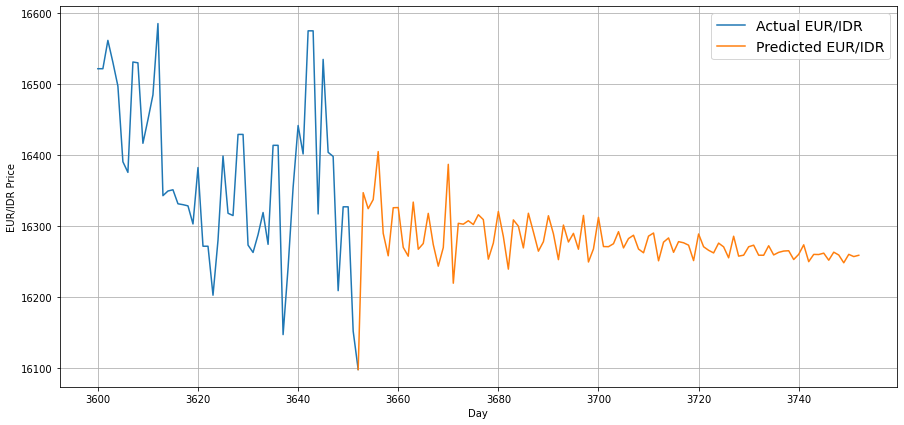

In [26]:
plt.figure(figsize=(15,7))
plot_time_series(time, series, start=3600, format="-", label="Actual EUR/IDR")
plot_time_series(next_time_steps, future_forecast, format="-", label="Predicted EUR/IDR")

The model is overfitting, which is why this is a bad model